# 1. Perkenalan

Nama : Dimas Liu, Batch : 001


# 2. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from plotter import *
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Untuk dendrogram Agglomerative Clustering
def plot_dendrogram(model, **kwargs):

    counts = zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def plot_silhouette(range_n_clusters,X):
    for n_clusters in range_n_clusters:

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)


        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)


            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")


        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        centers = clusterer.cluster_centers_

        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

# 3. Data Loading

In [4]:
df = pd.read_csv('CC General.csv')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [5]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
numeric_data = df._get_numeric_data()
numeric_data.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
4   817.714335           1.000000      16.00             16.00   
5  1809.828751           1.000000    1333.28              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   95.40      0.000000             0.166667   
1                    0.00   6442.945483             0.000000   
2                    0.00      0.000000             1.000000   
4                    0.00      0.000000             0.083333   
5                 1333.28      0.000000             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00                 0              2        1000.0   
1                    0.25                 4              0        7000.0   
2                    0.00                 0             12        7500.0   
4                    0.00                 0              1        1200.0   
5                    0.00                 0              8        1800.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
4   678.334763        244.791237          0.000000      12  
5  1400.057770       2407.246035          0.000000      12

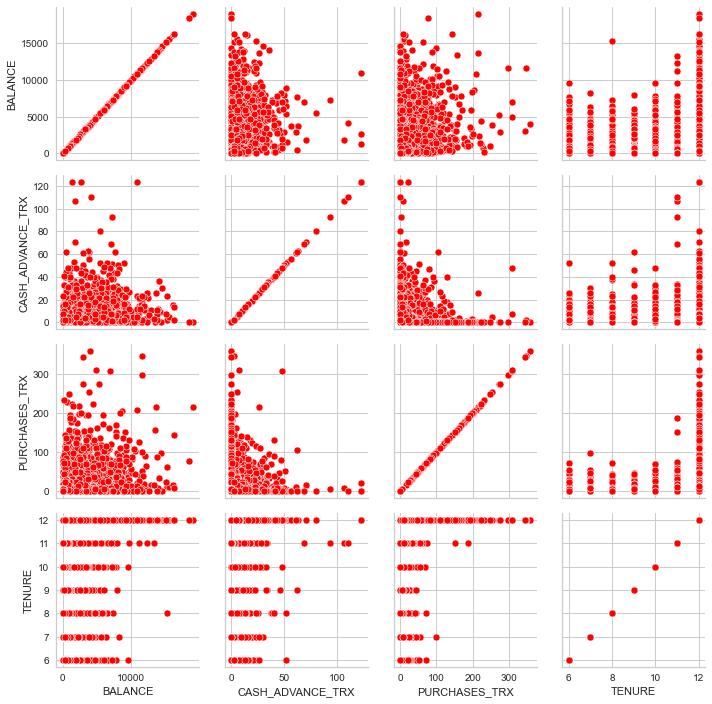

In [8]:
pair = sns.PairGrid(numeric_data, vars=['BALANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE'])
pair.map(sns.scatterplot, color='red')

In [9]:
del numeric_data['TENURE'] #variabel kategori.

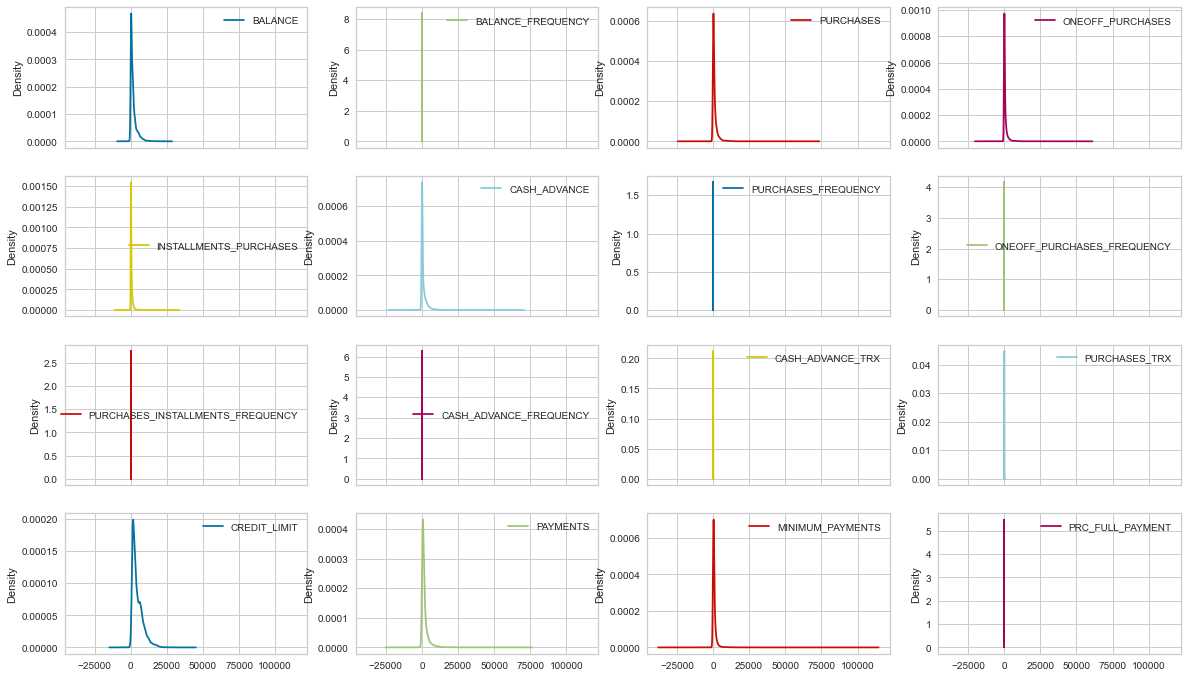

In [10]:
numeric_data.plot.kde(subplots=True, layout=(5,4), figsize=(20,15));

# Feature processing :

In [11]:
X = numeric_data

In [12]:
pca_2d=PCA(n_components=2).fit(X)

In [13]:
X2D=pca_2d.transform(X)

In [14]:
pca_3d = PCA(3)
pca_3d.fit(X)

PCA(n_components=3)

In [15]:
X3D=pca_3d.transform(X)

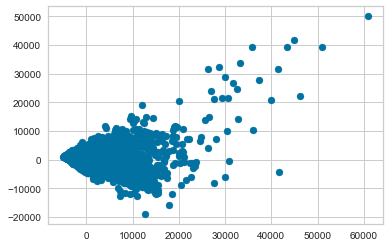

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(X2D[:,0], X2D[:,1]);

In [17]:
px.scatter_3d(x=X3D[:,0], y=X3D[:,1], z=X3D[:,2])

# K-Means :

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [20]:
kmeans.fit(X2D)
kmlabel = kmeans.labels_

In [21]:
from sklearn.metrics import silhouette_score
silhouette_score(X2D, kmlabel)

0.5039055488166027

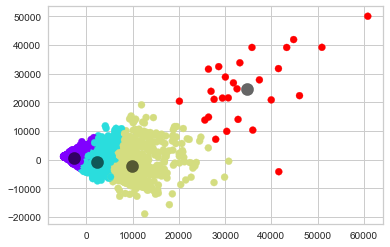

In [22]:
plt.figure(figsize=(6,4))
plt.scatter(X2D[:, 0], X2D[:, 1], c=kmlabel, cmap='rainbow')

centroid = kmeans.cluster_centers_
plt.scatter(centroid[:, 0], centroid[:, 1], c='black', s=150, alpha=0.6);

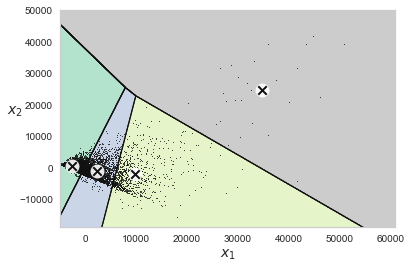

In [23]:
plt.figure(figsize=(6,4))
plot_decision_boundaries(kmeans, X2D)

In [25]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X2D)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X2D[:, 0], X2D[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

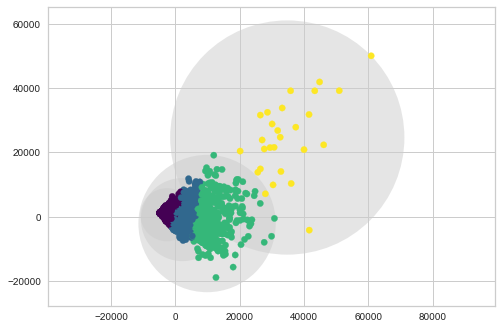

In [26]:
plot_kmeans(kmeans, X2D)

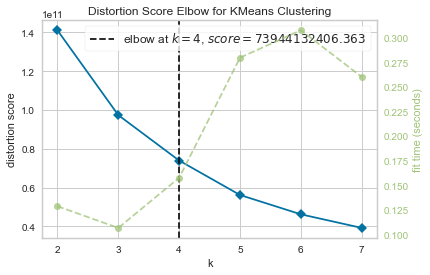

In [27]:
plt.figure(figsize=(6,4))
viz = KElbowVisualizer(kmeans, k=(2,8))
viz.fit(X2D)
viz.show();

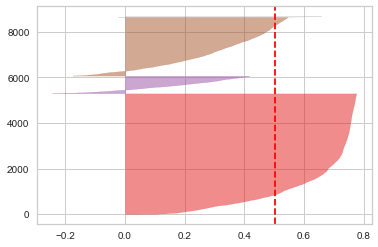

In [28]:
plt.figure(figsize=(6,4))
viskm = SilhouetteVisualizer(KMeans(4), color='yellowbrick')
viskm.fit(X2D);

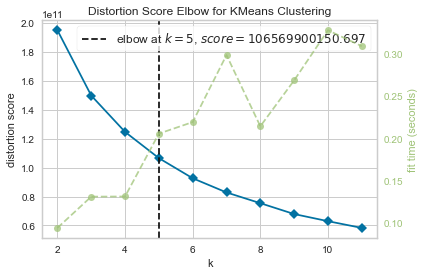

In [29]:
plt.figure(figsize=(6,4))
viz = KElbowVisualizer(kmeans, k=(2,12))
viz.fit(X3D)
viz.show();

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=5))

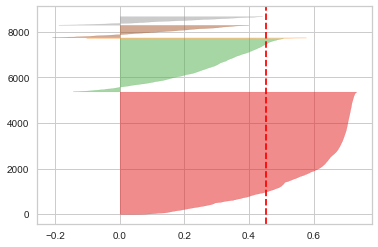

In [30]:
plt.figure(figsize=(6,4))
viskm3 =SilhouetteVisualizer(KMeans(5), color='yellowbrick')
viskm3.fit(X3D)

In [31]:
print(silhouette_score)

<function silhouette_score at 0x7fd1a764cd30>


# KMeans Cluster 3D :

In [32]:
kmeans3 = KMeans(n_clusters=5, random_state= 42)
kmeans3.fit(X3D)
kmlabel3 = kmeans3.labels_

In [33]:
px.scatter_3d(x=X3D[:,0], y=X3D[:,1], z=X3D[:,2], color=kmlabel3, opacity=0.8)

In [34]:
silhouette_score(X3D,kmlabel3)

0.4517622549950928

In [35]:
plt.style.use('seaborn-darkgrid')

# Agglomerative Clustering :

In [36]:
from sklearn.cluster import AgglomerativeClustering
agg= AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X2D)

In [37]:
agg.fit(X2D)

AgglomerativeClustering()

In [38]:
agg.labels_

array([1, 0, 1, ..., 1, 1, 1])

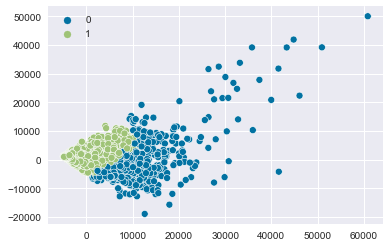

In [39]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=X2D[:,0],y=X2D[:,1],hue=agg.labels_);

# Agglomerative Dendrogram :

In [40]:
aggtree= AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggtree.fit(X2D)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

<ipython-input-2-f4e4c953642c>:4: DeprecationWarning:

scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead

<ipython-input-2-f4e4c953642c>:15: DeprecationWarning:

scipy.column_stack is deprecated and will be removed in SciPy 2.0.0, use numpy.column_stack instead



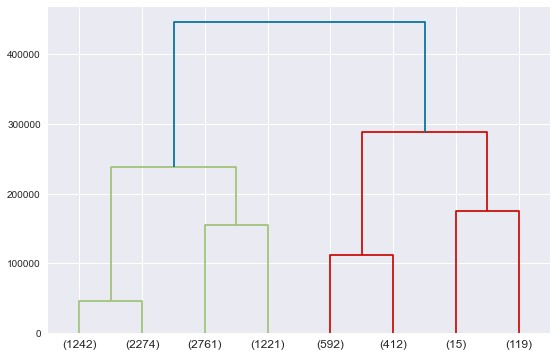

In [41]:
plt.figure(figsize=(9,6))
plot_dendrogram(aggtree, truncate_mode='level', p=2)

In [42]:
agglabels = agg.labels_

In [43]:
aggdendro = aggtree.labels_

In [44]:
print(silhouette_score(X2D, agglabels))

0.6182140381009058


# Deteksi Outlier memakai Mean Shift :

In [45]:
from sklearn.cluster import MeanShift

In [46]:
ms = MeanShift()
ms.fit(X2D)

MeanShift()

In [47]:
mscenter = ms.cluster_centers_

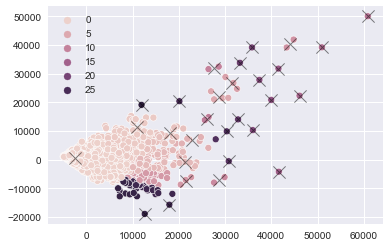

In [48]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=X2D[:,0], y=X2D[:,1], hue=ms.labels_)
sns.scatterplot(x=mscenter[:,0], y=mscenter[:,1], marker='x', s=150, alpha=0.5, color='black');

In [49]:
mslabel = ms.labels_

In [50]:
print("Mean Shift Silhouette Score : ",silhouette_score(X2D, mslabel))

Mean Shift Silhouette Score :  0.5568966922843138


# Model Evaluation :

# K-Means :
- Clustering dari K-Means menunjukkan kalau ada 4 kelompok, dimana 4 kelompok merepresentasikan 4 pengguna kredit card.
- 3 kelompok terlihat berdekatan, menunjukkan kalau setiap pengguna credit card memiliki behavior yang mirip, namun berbeda. Untuk yang kelompok ke-4 (yang dimaksud merupakan kelompok yang sangat jauh dari yang lain), merupakan kelompok yang memiliki behavior yang jauh berbeda dari ke-3 kelompok yang sama.

# Agglomerative Clustering :
- Clustering dari Agglomerative menjadi 2 kelompok lalu di split menjadi 4 bagian lagi. 2 kelompok berikut di representasikan dengan kelompok hijau & merah. Dimana ke-2 kelompok di split lagi menjadi 2 (masing-masing).
- Yang dimaksud dari dendrogram, masing2 akar memiliki behavior yang sama (berdasarkan kelompok warna), namun ada perbedaan di beberapa aspek.

# Mean Shift :

Meskipun Mean Shift melakukan sedikit kesalahan(deteksinya dengan representasi X), mendeteksi kalau ada nya outlier. Outlier di sini bisa diartikan beberapa arti ;
- Pengguna credit card kelewatan batas
- Pengguna credit card memiliki behavior yang tidak wajar.

Namun, di sini tidak bisa dilakukan asumsi, karena perlu analisis yang lebih untuk mencari arti dari setiap clustering.